# DREAM4 challenge with Boruta Shap    

This jupyter notebook applies the Boruta Shap inference method to the DREAM4 In Silico Size 100 Multifactorial subchallenge. Boruta shap is a statistical method which aims to recover a regulatory network from a data set containing the expression of some target variables and some predictor variables. It combines ensemble regression methods (Random Forest, Gradient boosting ...) as well as the Boruta method and the Shapley values to determine for each target the all-relevant subset of predictors.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

## 0. Load the data sets   

The DREAM4 In Silico Size 100 Multifactorial subchallenge gathers 5 regulatory networks which contain 100 genes. For each network a set of 100 static steady-state measurements are given ; they were obtained by slightly perturbing all genes simultaneously. Thus, for each network we load a data set of size 100x100 which contains the pertubated expression of each gene G1, ... , G100. The rows can be seen as expression profiles obtained from different patients or biological replicates.

In [2]:
dataframes = []
keys = ['Network ' + str(i) for i in range(1 , 6)]

for i in range(1 , 6):
    df = pd.read_csv('Size 100 multifactorial\DREAM4 training data\insilico_size100_' + str(i) + '_multifactorial.tsv' , sep = '\t')
    dataframes.append(df)

data = pd.concat(dataframes , keys=keys)

data.head()

G1        G2        G3        G4        G5        G6  \
Network 1 0  0.260809  0.377312  0.493373  0.182896  0.472203  0.440406   
          1  0.274420  0.333810  0.385739  0.058213  0.643646  0.345810   
          2  0.174974  0.313279  0.435140  0.153795  0.210283  0.163809   
          3  0.057877  0.415606  0.556997  0.057077  0.360422  0.365259   
          4  0.056687  0.501247  0.657297  0.061193  0.099516  0.159289   

                   G7        G8        G9       G10  ...       G91       G92  \
Network 1 0  0.613081  0.127030  0.557698  0.544354  ...  0.382850  0.540062   
          1  0.411500  0.526691  0.593392  0.359333  ...  0.381357  0.526589   
          2  0.528071  0.187572  0.570535  0.550161  ...  0.251150  0.582125   
          3  0.638240  0.229396  0.540217  0.192312  ...  0.423631  0.647272   
          4  0.619199  0.402479  0.585927  0.262629  ...  0.223723  0.576577   

                  G93       G94       G95       G96       G97       G98  \
Network 1 0  0.401710  0.010728  0.470598  0.077374  0.564423  0.477871   
          1  0.013718  0.007008  0.609810  0.133074  0.291613  0.446823   
          2  0.099479  0.031252  0.431763  0.120459  0.357971  0.393398   
          3  0.000762  0.008044  0.530413  0.277796  0.392910  0.346278   
          4  0.001685  0.006563  0.405007  0.122972  0.359634  0.284286   

                  G99      G100  
Network 1 0  0.032809  0.569960  
          1  0.006556  0.467766  
          2  0.030217  0.593467  
          3  0.002132  0.717003  
          4  0.000050  0.604840  

[5 rows x 100 columns]

This challenge being closed for several years now, we have access to the gold standards networks (i.e the "true" networks which were used ot obtain the pertubated expression profiles). We translate each of them into a binary adjacency matrix. We put NaN values on the diagonal since we do not consider self regulation in this challenge.

In [3]:
import csv 

def load_gs(file_name):
    tsv_file = open(file_name)
    read_tsv = csv.reader(tsv_file, delimiter="\t")
    df_gs = pd.DataFrame(index = df.columns , columns = df.columns)
    for row in read_tsv:
        df_gs.loc[row[0] , row[1]] = int(row[2])
    return df_gs

dataframes = []
for i in range(1 , 6):
    dataframes.append(load_gs('Size 100 multifactorial\DREAM4 gold standards\insilico_size100_multifactorial_' + str(i) + '_goldstandard.tsv'))

gold_standards = pd.concat(dataframes , keys=keys)

gold_standards.head()

G1   G2   G3   G4   G5 G6 G7 G8 G9 G10  ... G91 G92 G93 G94  \
Network 1 G1  NaN    0    0    0    0  0  0  0  0   0  ...   0   0   0   0   
          G2    0  NaN    0    0    0  0  0  0  0   0  ...   1   0   0   0   
          G3    0    0  NaN    0    0  0  0  0  0   0  ...   0   0   0   0   
          G4    0    0    0  NaN    0  0  0  0  0   0  ...   0   0   0   0   
          G5    0    0    0    0  NaN  0  0  0  0   0  ...   0   0   0   0   

             G95 G96 G97 G98 G99 G100  
Network 1 G1   0   0   0   0   0    0  
          G2   0   0   0   0   0    0  
          G3   0   0   0   0   0    0  
          G4   0   0   0   0   0    0  
          G5   0   0   0   0   0    0  

[5 rows x 100 columns]

## 1. Boruta Shap inference for Gene Regulatory Networks (GRNs)

We consider the pertubated data set $\mathcal{D} = (g_1 , ... , g_P) \, \in \, \mathbb{R}^{N \times P}$ (where $P = 100$ is the number of genes/features and $N = 100$ is the number of samples). For each gene $g_i \, (i = 1, ..., 100)$ we want to select all the genes $g_j \, (j \ne i)$ that interact with $g_i$.   

Our Boruta Shap method addresses this challenge using a feature selection strategy. More specifically, for each gene $g_i \, (i = 1, ..., 100)$, it solves the following regression problem with an ensemble method :
$$ g_i \, \sim \, \{ g_j \, , \, j \ne i \} $$   

**Note :** in this notebook we used a Random Forest regressor, but it works also well with other ensemble methods such as XGBoost for instance.   

For selecting all the relevant predictors we use the Boruta method which consists in iterating the regression several times and comparing the feature importances of the predictors with those of shadow variables (i.e shuffled variables). The hypothesis of this method is that the relevant predictors should be significantly more important than the shadow varaibles over the different runs.   

To measure the feature importances with ensemble regression methods, we use mean absolute Shapley values.

In [4]:
from sklearn.ensemble import RandomForestRegressor
from algorithms.BorutaShap import Shap , BoShapNet

In [5]:
regressor = Shap(RandomForestRegressor(n_jobs = -1 , max_features = 1/3 , max_depth = 3))

select = []

for key in keys:
    start = time.time()
    df = data.loc[key]
    BoShap = BoShapNet(regressor = regressor , responses = list(df.columns) , predictors = list(df.columns) , n_jobs = -1)
    BoShap.fit(df)
    select.append(BoShap.selections_)
    end = time.time()
    minutes, seconds = divmod(end - start, 60)
    print(key + " done !" , "running time (min): " + "{:0>2}:{:05.2f}".format(int(minutes),seconds))
    
selections = pd.concat(select , keys=keys)
selections.head()

Network 1 done ! running time (min): 11:45.49
Network 2 done ! running time (min): 12:40.68
Network 3 done ! running time (min): 13:38.15
Network 4 done ! running time (min): 13:57.04
Network 5 done ! running time (min): 13:28.73


G1   G2   G3   G4   G5   G6   G7   G8   G9  G10  ...  G91  G92  \
Network 1 G1  NaN  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
          G2  0.0  NaN  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0   
          G3  0.0  0.0  NaN  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
          G4  0.0  0.0  0.0  NaN  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
          G5  0.0  0.0  0.0  0.0  NaN  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

              G93  G94  G95  G96  G97  G98  G99  G100  
Network 1 G1  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  
          G2  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  
          G3  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  
          G4  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  
          G5  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  

[5 rows x 100 columns]

Here, we tackle a slightly less difficult problem than the original one : we simply try to detect undirected associations. In other words, for an association $g_i \rightarrow g_j$ in the gold standards data we will consider a True positive the detection of the associations $g_i \rightarrow g_j$, $g_j \rightarrow g_i$ or both.   

Thus for our gold standard adjacency matrix G and our predicted adjacency matrix P we want to compare $\mathbf{1}_{G_{ij} + G_{ji} \geq 1}$ and $\mathbf{1}_{P_{ij} + P_{ji} \geq 1}$. To do so, we sum the upper and lower triangular adjacency matrices (cf undirected confusion function).

In [6]:
from sklearn.metrics import confusion_matrix

def undirected_confusion(df_pred , df_true):
    indexes = np.triu_indices(df_pred.shape[0] , 1)
    y_pred = 1*(((df_pred.T.values)[indexes] + (df_pred.values)[indexes]) > 0)
    y_true = 1*(((df_true.T.values)[indexes] + (df_true.values)[indexes]) > 0)
    return confusion_matrix(y_true, y_pred)

recall = lambda cm: cm[1,1]/(cm[1,0]+cm[1,1])
precision = lambda cm: cm[1,1]/(cm[1,1] + cm[0,1])
F1_score = lambda p , r: 2*(p*r)/(p + r)

In [7]:
results = np.zeros((5 , 3))

for i in range(5):
    key = keys[i]
    cm_u = undirected_confusion(selections.loc[key] , gold_standards.loc[key])
    results[i , :] = (precision(cm_u) , recall(cm_u) , F1_score(precision(cm_u) , recall(cm_u)))
    
results = pd.DataFrame(results , columns = ['precision' , 'recall' , 'F1 score'] , index = keys)
results

,precision,recall,F1 score
Network 1,0.333333,0.260355,0.292359
Network 2,0.409449,0.214876,0.281843
Network 3,0.375566,0.432292,0.401937
Network 4,0.346491,0.381643,0.363218
Network 5,0.396985,0.413613,0.405128


Text(0.5, 1.0, 'Dream4 - Boruta Shap : undirected links')

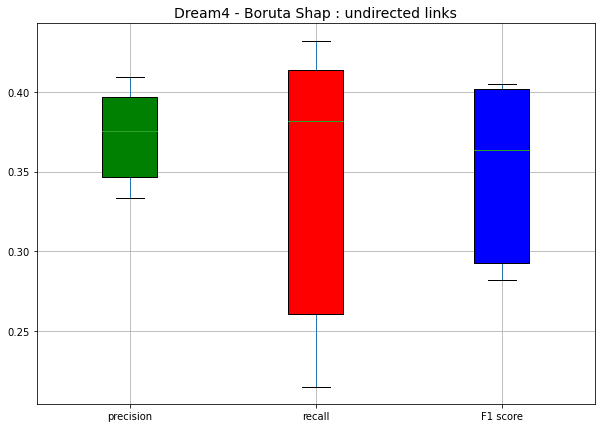

In [8]:
fig , ax = plt.subplots(figsize = (10 , 7))

boxplot = results.boxplot(return_type = 'dict' , patch_artist = True , ax = ax)
colors = ['green' , 'red' , 'blue']

for i in range(3):
    boxplot['boxes'][i].set_color(colors[i])
    boxplot['boxes'][i].set_edgecolor('k')

ax.set_title("Dream4 - Boruta Shap : undirected links" , fontsize  =14)

## 2. Comparison with state-of-the-art methods : GENIE3 and TIGRESS   

Both methods rely on the same idea than our Boruta Shap method : they use regression models and feature selection tools to select all the relevant predictors $g_j \, (j \ne i)$ associated to a target $g_i$.   

However, contrary to our method, they do not provide a definitive partitionning between relevant associations (1 in the adjacency matrix) and non-relevant ones (0 in the adjacency matrix). They compute a score for each possible association  allowing the user to rank them from the most probable (maximum score) to the least probable (minimum score). The choice of the threshold which separates "true" associations from "false" ones is let to the user.   

To compare GENIE3 and TIGRESS with Boruta Shap we will choose a thresold that maximizes the F1 score for TIGRESS and GENIE3 and compare these scores with the F1 score obtained with Boruta Shap.   

**Note :** again we deal with undirected associations. Thus, for both TIGRESS and GENIE3 methods the score associated with $g_i \leftrightarrow g_j$ will simply be the maximum between the score associated with $g_i \rightarrow g_j$ and the one associated with  $g_j \rightarrow g_i$.

In [10]:
from sklearn.metrics import precision_recall_curve

def pr_curve(df_pred , df_true):
    """" Plot the precision and recall curve in the case of undirected associations 
    """
    indexes = np.triu_indices(df_pred.shape[0] , 1)
    y_scores = np.maximum((df_pred.values.T)[indexes] , (df_pred.values)[indexes])
    y_true = 1*((df_true.values.T)[indexes] + (df_true.values)[indexes] > 0)
    return precision_recall_curve(y_true, y_scores)

### 2.1 GENIE3   

GENIE3 uses Random Forest regressors and the Gini importance score (Mean Decrease in Impurity). The scores are aggregated over all the regressions to provide a global ranking of associations.   

For more details please refer to the article ["Inferring Regulatory Networks from Expression Data Using Tree-Based Methods" Huynh-Thu et al. 2010](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0012776). For a python implementation, please refer to the github page https://github.com/vahuynh/GENIE3.

**Note :** we slightly modified the GENIE3.py file to simplify the display (comment some print lines).

In [4]:
from GENIE3 import *

C:\Users\ncaptier\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


In [7]:
scores = []

for key in keys:
    start = time.time()
    df = data.loc[key]
    VIM = GENIE3(df.values , nthreads = 8)
    out = pd.DataFrame(VIM , index = df.columns , columns = df.columns)
    scores.append(out)
    end = time.time()
    minutes, seconds = divmod(end - start, 60)
    print(key + " done !" , "running time (min): " + "{:0>2}:{:05.2f}".format(int(minutes),seconds))
    
scores = pd.concat(scores , keys=keys)
scores.head()

Network 1 done ! running time (min): 00:37.63
Network 2 done ! running time (min): 00:40.48
Network 3 done ! running time (min): 00:40.60
Network 4 done ! running time (min): 00:46.76
Network 5 done ! running time (min): 00:48.60


G1        G2        G3        G4        G5        G6  \
Network 1 G1  0.000000  0.006873  0.013194  0.012337  0.009871  0.009025   
          G2  0.009445  0.000000  0.008059  0.007972  0.003979  0.006319   
          G3  0.010393  0.007998  0.000000  0.014099  0.008717  0.007737   
          G4  0.009545  0.007152  0.014458  0.000000  0.007726  0.006656   
          G5  0.014817  0.006355  0.010394  0.014025  0.000000  0.016714   

                    G7        G8        G9       G10  ...       G91       G92  \
Network 1 G1  0.011716  0.004430  0.007232  0.006863  ...  0.010831  0.004372   
          G2  0.004917  0.006026  0.015191  0.016277  ...  0.064100  0.006719   
          G3  0.013298  0.006286  0.007288  0.005599  ...  0.009425  0.003404   
          G4  0.011105  0.004994  0.011238  0.007149  ...  0.012497  0.008674   
          G5  0.007561  0.004898  0.015136  0.008583  ...  0.012619  0.002958   

                   G93       G94       G95       G96       G97       G98  \
Network 1 G1  0.007522  0.010221  0.012172  0.004289  0.005677  0.006202   
          G2  0.006803  0.004165  0.011061  0.016384  0.008090  0.027311   
          G3  0.007855  0.002923  0.009603  0.016859  0.005663  0.007793   
          G4  0.005781  0.005075  0.006205  0.011775  0.007432  0.020988   
          G5  0.003319  0.002311  0.007419  0.007088  0.004286  0.005551   

                   G99      G100  
Network 1 G1  0.014171  0.009382  
          G2  0.002756  0.008913  
          G3  0.002502  0.015236  
          G4  0.006849  0.006898  
          G5  0.002205  0.005947  

[5 rows x 100 columns]

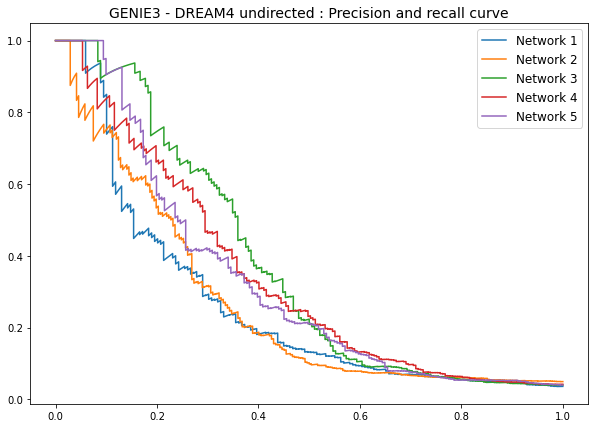

In [14]:
plt.figure(figsize = (10 , 7))

results = []

for key in keys:
    precision, recall, thresholds = pr_curve(scores.loc[key] , gold_standards.loc[key])
    results.append(np.amax(2*(precision*recall)/(precision + recall)))
    plt.plot(recall , precision , label = key)
    
plt.title('GENIE3 - DREAM4 undirected : Precision and recall curve' ,fontsize = 14)
plt.legend(fontsize = 12)

In [15]:
results = pd.DataFrame(results , columns = ['max F1 score'] , index = keys)
results

,max F1 score
Network 1,0.316129
Network 2,0.323760
Network 3,0.429487
Network 4,0.379947
Network 5,0.366197


### 2.2. TIGRESS   

TIGRESS method combines regularized regressions (Lasso, LARS ...) and stability selection (i.e it repeats several times the regression over different resampled data sets and computes the frequencies with which the associations are selected).   

For more details, please refer to the article ["TIGRESS: Trustful Inference of Gene REgulation using Stability Selection" Haury et al. 2012"](https://bmcsystbiol.biomedcentral.com/articles/10.1186/1752-0509-6-145). In this repository, we propose our own python implementation of this method.

In [18]:
from algorithms.TIGRESS import TIGRESS

In [20]:
scores = []

for key in keys:
    start = time.time()
    df = data.loc[key]
    T = TIGRESS(responses = list(df.columns) , predictors = list(df.columns))
    T.fit(df , normalize = True)
    scores.append(T.scores_)
    end = time.time()
    minutes, seconds = divmod(end - start, 60)
    print(key + " done !" , "running time (min): " + "{:0>2}:{:05.2f}".format(int(minutes),seconds))
    
scores = pd.concat(scores , keys=keys)
scores.head()

Network 1 done ! running time (min): 02:37.65
Network 2 done ! running time (min): 02:42.26
Network 3 done ! running time (min): 02:42.42
Network 4 done ! running time (min): 02:36.00
Network 5 done ! running time (min): 02:37.69


G1        G2        G3        G4        G5        G6  \
Network 1 G1       NaN  0.009500  0.051313  0.008250  0.033500  0.002250   
          G2  0.000375       NaN  0.023187  0.000500  0.000063  0.002687   
          G3  0.028125  0.008375       NaN  0.030875  0.000313  0.000250   
          G4  0.009000  0.001250  0.034625       NaN  0.001187  0.003188   
          G5  0.001875  0.000125  0.000063  0.000063       NaN  0.016625   

                    G7        G8        G9       G10  ...       G91       G92  \
Network 1 G1  0.002812  0.001188  0.011875  0.000875  ...  0.054125  0.005625   
          G2  0.000313  0.002375  0.001563  0.003063  ...  0.019312  0.000000   
          G3  0.022625  0.000375  0.000688  0.000375  ...  0.001750  0.000000   
          G4  0.001687  0.000438  0.008438  0.001937  ...  0.027000  0.008938   
          G5  0.000563  0.000125  0.001063  0.000500  ...  0.001625  0.000000   

                   G93       G94       G95       G96       G97       G98  \
Network 1 G1  0.000875  0.007750  0.015062  0.002812  0.001063  0.001125   
          G2  0.003063  0.002250  0.003563  0.003063  0.001938  0.009750   
          G3  0.004625  0.000000  0.004375  0.013125  0.000250  0.006125   
          G4  0.001813  0.002437  0.001063  0.001437  0.000875  0.030625   
          G5  0.000125  0.000000  0.000250  0.001437  0.000063  0.000500   

                   G99      G100  
Network 1 G1  0.009000  0.030500  
          G2  0.000375  0.000000  
          G3  0.000000  0.000250  
          G4  0.057375  0.002687  
          G5  0.000000  0.000125  

[5 rows x 100 columns]

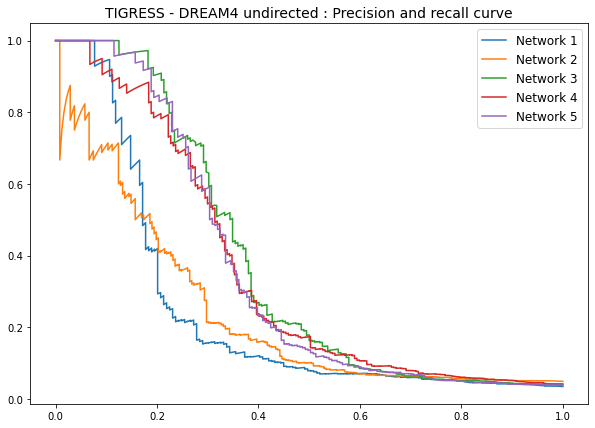

In [23]:
plt.figure(figsize = (10 , 7))

results = []

for key in keys:
    precision, recall, thresholds = pr_curve(scores.loc[key] , gold_standards.loc[key])
    results.append(np.amax(2*(precision*recall)/(precision + recall)))
    plt.plot(recall , precision , label = key)
    
plt.title('TIGRESS - DREAM4 undirected : Precision and recall curve' ,fontsize = 14)
plt.legend(fontsize = 12)

In [22]:
results = pd.DataFrame(results , columns = ['max F1 score'] , index = keys)
results

,max F1 score
Network 1,0.272000
Network 2,0.304762
Network 3,0.413793
Network 4,0.395137
Network 5,0.401384


## Conclusion

This short experiment showed quite satisfying results : though our Boruta Shap method is more computationally demanding than TIGRESS and GENIE3 methods, it achieves comparable F1 scores. Besides, it does not need any thresold specification. It means that our method is able to automatically reach scores that would require an optimal choice for the thresold if we were using TIGRESS or GENIE3.